# Wieloboki Voronoi'a

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test1 import Test
from bitalg.visualizer.main import Visualizer

In [13]:
def draw_points(points):
    vis = Visualizer()
    vis.add_point(points, s=2, color='green')
    vis.show()

In [32]:
def draw_tri(triangleList):
    vis = Visualizer()
    points = set()
    sides = set()
    for triangle in triangleList:
        a = (triangle.a.x, triangle.a.y)
        b = (triangle.b.x, triangle.b.y)
        c = (triangle.c.x, triangle.c.y)
        points.add(a)
        points.add(b)
        points.add(c)
        sides.add((a, b))
        sides.add((b, c))
        sides.add((c, a))
    

    vis.add_point(list(points))
    vis.add_line_segment(list(sides), color='red')
    vis.show()

In [15]:
def generate_uniform_points(left, right, n = 10 ** 5):
    tab =[]
    for _ in range(n):
        x = np.random.uniform(left, right)
        y = np.random.uniform(left, right)
        tab.append((x, y))
    return tab

**Funkcje pomocnicze**

In [28]:
def orient(a, b, c):
    return (b.x-a.x)*(c.y-b.y) - (b.y-a.y)*(c.x-b.x)
# ...

**Klasy**

In [56]:
# parametr epsilon
eps = 10*-12

class Point():
    def __init__(self,point):
        self.x = point[0]
        self.y = point[1]

    def __eq__(self, other):
        return abs(self.x-other.x)<eps and abs(self.y-other.y)<eps
    
    def __hash__(self):
        return hash((self.x, self.y))


class Triangle():
    def __init__(self,a,b,c):
        self.a = a
        self.b = b
        self.c = c
        self.isCorrect = True

    def __eq__(self, other):
        return self.a==other.a and self.b==other.b and self.c==other.c
    
    def __hash__(self):
        return hash((self.a, self.b, self.c))
    
    def containsPoint(self, point):
        side1 = orient(self.a, self.b, point)
        side2 = orient(self.b, self.c, point)
        side3 = orient(self.c, self.a, point)
        isOnLeft = side1<0 and side2<0 and side3<0
        isOnRight = side1>0 and side2>0 and side3>0
        return isOnLeft or isOnRight
    
    def circumcircleContainsPoint(self, point):
        ax_ = self.a.x-point.x
        ay_ = self.a.y-point.y
        bx_ = self.b.x-point.x
        by_ = self.b.y-point.y
        cx_ = self.c.x-point.x
        cy_ = self.c.y-point.y
        return (
            (ax_*ax_ + ay_*ay_) * (bx_*cy_-cx_*by_) -
            (bx_*bx_ + by_*by_) * (ax_*cy_-cx_*ay_) +
            (cx_*cx_ + cy_*cy_) * (ax_*by_-bx_*ay_)
        ) < 0
    
    def sharesEdge(self, edge):
        x = Point(edge[0])
        y = Point(edge[1])
        trianglePoints = [self.a, self.b, self.c]
        return x in trianglePoints and y in trianglePoints

**Algorytmy**

In [58]:
# https://www.baeldung.com/cs/voronoi-diagram
def Bowyer_Watson(points):
    pointList = []
    for point in points:
        newPoint = Point(point)
        pointList.append(newPoint)

    # print("!")
    # print(pointList)
    triangleList = []
    superA = Point((200,-200))
    superB = Point((-200,-200))
    superC = Point((0,200))
    superTriangle = Triangle(superA, superB, superC)
    triangleList.append(superTriangle)

    for point in pointList:
        edgeList = set()
        for triangle in triangleList:
            if triangle.circumcircleContainsPoint(point):
                triangle.isCorrect=False
                a = triangle.a
                b = triangle.b
                c = triangle.c
                edgeList.add((a, b))
                edgeList.add( (b, c))
                edgeList.add((c, a))

        for triangle in triangleList:
            if triangle.isCorrect==False: triangleList.remove(triangle)

        # to do
        #for edge in edgeList:
            # if edge is shared by any other triangles:
            #    edgeList.remove(edge)

        for edge in edgeList:
            triangle = Triangle(edge[0], edge[1], point)
            triangleList.append(triangle)
    
    a = superTriangle.a
    b = superTriangle.b
    c = superTriangle.c
    for triangle in triangleList:
        if triangle.containsPoint(a) or triangle.containsPoint(b) or triangle.containsPoint(c):
            triangleList.remove(triangle)
    
    return triangleList

**Testy**

[<__main__.Triangle object at 0x00000221ED823290>, <__main__.Triangle object at 0x00000221ED820DD0>, <__main__.Triangle object at 0x00000221ED821BE0>, <__main__.Triangle object at 0x00000221ED840AD0>, <__main__.Triangle object at 0x00000221ED841430>, <__main__.Triangle object at 0x00000221ED8419A0>, <__main__.Triangle object at 0x00000221ED843230>, <__main__.Triangle object at 0x00000221ED8434D0>, <__main__.Triangle object at 0x00000221ED8439B0>, <__main__.Triangle object at 0x00000221ED843BF0>, <__main__.Triangle object at 0x00000221ED823770>, <__main__.Triangle object at 0x00000221ED843B00>, <__main__.Triangle object at 0x00000221ED8422A0>, <__main__.Triangle object at 0x00000221ED843CB0>, <__main__.Triangle object at 0x00000221ED858050>, <__main__.Triangle object at 0x00000221ED858650>, <__main__.Triangle object at 0x00000221ED858770>, <__main__.Triangle object at 0x00000221ED8228A0>, <__main__.Triangle object at 0x00000221ED841B20>, <__main__.Triangle object at 0x00000221ED842F00>,

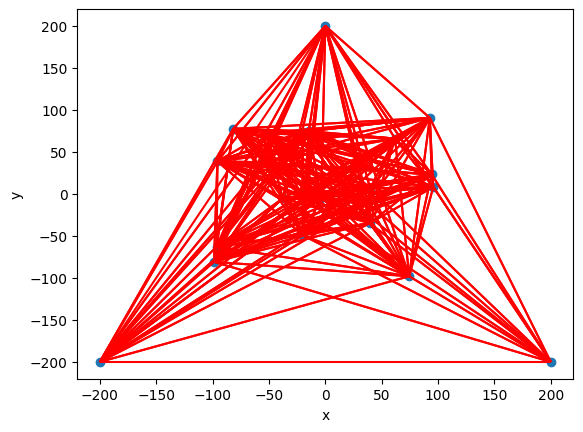

In [59]:
# nie działa
randomPoints = generate_uniform_points(-100, 100, 20)
triangulation = Bowyer_Watson(randomPoints)
print(triangulation)
draw_tri(triangulation)

**Główny algorytm**


In [19]:
def Voronoi(points):
    '''
    points = [(x1, y1), (x2, y2), ...]
    '''
    # ...
    pass



**Testy algorytmu**